In [1]:
import os
import numpy as np
import pandas as pd
import csv
from youtubesearchpython import Transcript, Comments, Video, VideosSearch
from tqdm import tqdm
COMMENT_PATH = 'InitDataset/comments.csv'
TRANSCRIPT_FOLDER = "InitDataset/Transcripts/"
INFO_PATH = "InitDataset/infos.csv"
LOG_ERROR_PATH = "DataCollection/error_log.csv"
LOG_SUCCESS_PATH = "DataCollection/success_log.csv"

# 1. Data Collection

In [2]:
# 重新搜集
error_df = pd.read_csv(LOG_ERROR_PATH)
success_df = pd.read_csv(LOG_SUCCESS_PATH)
vids = set(error_df.id) | set(success_df.id)

In [64]:
# 两轮收完之后，总觉得有点问题 transcript 少了才4k 不对劲
vids = set(info_df['vid'])
len(vids)

8303

## 1.1 Search Video

In [14]:
KEYWORDS = ('News', 'Sport','Food', 'Game', 'Fashion', 'Entertainment', 'Tech', 'Education', 'Motivation', 'Vlog', 'Art', 'Music')
video_path = 'InitDataset/videos.csv'
video_column = ['vid', 'tag']
if not os.path.exists(video_path):
    with open(info_path, 'a') as f:
        writer = csv.DictWriter(f, fieldnames=video_column)
        writer.writeheader()

In [15]:
for tag in KEYWORDS:
    count = 0
    videosSearch = VideosSearch(tag, limit=100)
    results = videosSearch.result()['result']
    while count <= 1500 and len(results) != 0:
        results = []
        try:
            videos = videosSearch.result()['result']
            for video in videos:
                result = dict()
                result['vid'] = video['id']
                result['tag'] = tag
                results.append(result)
                
            with open(video_path, 'a') as f:
                writer = csv.DictWriter(f, fieldnames=video_column)
                writer.writerows(results)
        except Exception as e:
            with open('InitDataset/log.csv', 'a') as f:
                text = ','.join([vid, 'id',str(e)+'\n'])
                f.write(text)
        
        count += len(results)
        videosSearch.next()

In [17]:
video_df = pd.read_csv(video_path)
vids = set(video_df['vid'])

## 1.2 Collect Video Information

In [20]:
info_column = ['vid', 'title', 'duration', 'views']
info_path = 'InitDataset/infos.csv'
if not os.path.exists(info_path):
    with open(info_path, 'a') as f:
        writer = csv.DictWriter(f, fieldnames=info_column)
        writer.writeheader()

In [21]:
# get video information
infos = []
for vid in tqdm(vids):
    try:
        video = Video.get(vid)
        info = dict()
        info['vid'] = video['id']
        info['title'] = video['title'].strip()
        info['duration'] = video['duration']['secondsText']
        info['views'] =  video['viewCount']['text']
        infos.append(info)
    except Exception as e:
        with open('InitDataset/log.csv', 'a') as f:
            text = ','.join([vid, 'transcript',str(e)+'\n'])
            f.write(text)

100%|██████████| 5314/5314 [22:44<00:00,  3.90it/s]


In [30]:
with open(info_path, 'a') as f:
    writer = csv.DictWriter(f, fieldnames=info_column)
    writer.writerows(infos)

## 1.3 Video Comment

In [18]:
columns = ['vid', 'uid', 'content', 'votes']
comments_path = 'InitDataset/comments.csv'
if not os.path.exists(comments_path):
    with open(comments_path, 'a') as f:
        writer = csv.DictWriter(f, fieldnames=columns)
        writer.writeheader()

In [19]:
for vid in tqdm(vids):
    results = []
    page = 0
    try:
        comments_response = Comments(vid)
        while page < 5 and comments_response.hasMoreComments:
            comments = comments_response.comments["result"]
            for comment in comments:
                result = dict()
                result['vid'] = vid
                result['uid'] = comment["id"]
                result['content'] = comment["content"].strip()
                result['votes'] = comment["votes"]['simpleText']
                results.append(result)
            page += 1
            comments_response.getNextComments()
        with open(comments_path, 'a') as f:
            writer = csv.DictWriter(f, fieldnames=columns)
            writer.writerows(results)
    except Exception as e:
        with open('InitDataset/log.csv', 'a') as f:
            text = ','.join([vid, 'comment',str(e)+'\n'])
            f.write(text)

100%|██████████| 5314/5314 [3:23:34<00:00,  2.30s/it]  


## 1.4 Transcript

In [66]:
nan_trans_vids = []
for vid in vids:
    path = os.path.join('InitDataset/Transcripts', vid+'.csv')
    if not os.path.exists(path): 
        nan_trans_vids.append(vid)

In [67]:
len(nan_trans_vids)

4242

In [42]:
columns = ['vid', 'start', 'end', 'text']
transcript_path = 'InitDataset/Transcripts'

In [41]:
for vid in tqdm(vids):
    path = os.path.join('InitDataset/Transcripts', vid+'.csv')
    if os.path.exists(path):
        continue
    try:
        transcript = Transcript.get(vid)
        # ========== check language ===========
        languages = pd.DataFrame.from_dict(transcript['languages'])
        # 语言选项为空 - transcrtipt没有实际内容
        if languages.empty:
            continue
        # check if ENGLISH
        selected_language = languages[languages['selected'] == True]
        if 'English' in selected_language['title'].item():
            segments = transcript['segments']
        else:
            # If not ENGLISH, check if ENGLISH version is available
            para = languages[languages['title'] == "English"]['params']
            if not para.empty:
                para = para.item()
                transcript = Transcript.get(vid, para)
                segments = transcript['segments']
            else:
                # report Failure
                with open('InitDataset/log.csv', 'a') as f:
                    text = ','.join([vid, 'Transcript', 'No English Version Found\n'])
                    f.write(text)
                continue
        # ====================================
        
        # ============ parse data ============
        results = []
        for segment in segments:
            result = dict()
            result['vid'] = vid
            result['start'] = segment['startMs']
            result['end'] = segment['endMs']
            result['text'] = segment['text'].replace('\n', ' ')
            results.append(result)
        
        path = os.path.join(transcript_path, vid+'.csv')
        with open(path, 'w') as f:
            writer = csv.DictWriter(f, fieldnames=columns)
            writer.writeheader()
            writer.writerows(results)
        # ====================================
    except Exception as e:
        with open('InitDataset/log.csv', 'a') as f:
            text = ','.join([vid, 'Transcript',str(e)+'\n'])
            f.write(text)
        

  6%|▋         | 345/5314 [01:36<23:16,  3.56it/s]


KeyboardInterrupt: 

## 1. 5 Data Summary
刚收集完的数据
* comment **222w** 2219423
* info **1.04w** 10439
* transcript **1678**

In [3]:
comment_df = pd.read_csv('InitDataset/comments.csv')
comment_df

,vid,uid,content,votes
0,G6mag86ktZA,UgwXmoHRaXCeROsnh5F4AaABAg,The only thing cheating in art is claiming an ...,15K
1,G6mag86ktZA,UgwLNU7F7oB8kVnVuWV4AaABAg,"""There is no cheating in art""",1.1K
2,G6mag86ktZA,UgzzBJe9Ly93M1zgbWV4AaABAg,“Don’t listen to ppl you never met on the inte...,140
3,G6mag86ktZA,UgxE92cFu5sMoLRBa8t4AaABAg,Also tracing can help you get used to differen...,1.7K
4,G6mag86ktZA,UgxC92Pvqcnm0QqNQ0B4AaABAg,"""There's only one rule and that is to have fun.""",70
...,...,...,...,...
2219418,K24iHkQ4umE,UgyGNIGaZz5kBLXdf6J4AaABAg,අරගලය මෙහෙයවන්නේ බටහිර ඉත්තෝ ! උන්ට රැවටෙන්න එ...,6
2219419,K24iHkQ4umE,UgyYNP578HYbcTn9yXF4AaABAg,GOTTAWA MARALA KAPALA GATANA KARAPAN NATHAM PU...,NaN
2219420,K24iHkQ4umE,Ugyl0T6MihWkvfqEAIt4AaABAg,GOTTATA PUK PUK GANA SINGHALA VASA GANU SINGH...,NaN
2219421,K24iHkQ4umE,UgznIvU5IsXZLk21XXx4AaABAg,Chathura hora,2


In [4]:
info_df = pd.read_csv('InitDataset/infos.csv')
info_df

,vid,title,duration,views
0,G6mag86ktZA,Is there such a thing as Cheating in Art?,52.0,1660431.0
1,ovxXYMsz37g,The Price of Education In China | Gen 跟 China,890.0,139509.0
2,B5GrU_ZgHwc,Poco F1 - World’s BEST Flagship Killer!,414.0,355078.0
3,zCe72UH4Mto,Food Storage Tour For Family Of 14 🥳😁😘 #shorts,60.0,357259.0
4,MeNlYwUpduU,Mit diesem 10-Minuten-Workout verbrennst du or...,605.0,1174834.0
...,...,...,...,...
10434,FMQyW5Dktdw,"Tech House Mix 2021 (Fisher, James Hype, Cloon...",3943.0,2053418.0
10435,w15pCPU2-cA,Nothing Phone (1) Indian Retail Unit Unboxing ...,806.0,2809943.0
10436,_1AjMAPtmtQ,Japan swelters in its worst heatwave ever reco...,178.0,1343490.0
10437,sXdfRYyzbmU,Elon Musk Wants to Revolutionize Education,151.0,1255927.0


In [5]:
'count of transcript: ' + str(len(os.listdir('InitDataset/Transcripts/')))

'count of transcript: 4144'

# 2. Data Pre-process


## 2.1 Drop Empty & Duplicate

### 2.1.1 去除没有获取到内容的内部信息

In [2]:
info_df = pd.read_csv('InitDataset/infos.csv')
comment_df = pd.read_csv('InitDataset/comments.csv')

In [3]:
# 检查三者的为空情况
pass

In [4]:
# transcript 有75个video是空的，lines <5 -> 空
nan_transcript_ids = set()
for file in os.listdir(TRANSCRIPT_FOLDER):
    if file == '.DS_Store':
        continue
    with open(os.path.join(TRANSCRIPT_FOLDER, file), 'r')as f:
        lines = f.readlines()
        if len(lines) <= 5:
            vid = file.split('.')[0]
            nan_transcript_ids.add(vid)
len(nan_transcript_ids)

0

In [5]:
import shutil
# 删除内部为空信息
# transcript
for vid in nan_transcript_ids:
    file_path = os.path.join(TRANSCRIPT_FOLDER, vid+'.csv')
    shutil.move(file_path, 'InitDataset/deletedTranscripts/' + vid+'.csv') 
# comment
comment_df = comment_df.dropna(subset=['content'])
# info
info_df = info_df.dropna(subset=['title'])

In [6]:
print('Count:')
print('Information: {}'.format(info_df.shape[0]))
print('Comments: {}'.format(comment_df.shape[0]))
print('Transcript: {}'.format(len(os.listdir(TRANSCRIPT_FOLDER))))

Count:
Information: 10439
Comments: 2219406
Transcript: 2949


### 2.1.2 删除冗余信息
因为vid是唯一的，而transcript与vid是一一对应关系，transcript不可能有冗余信息

In [7]:
# Comment & Info 删除冗余信息，
comment_df = comment_df.drop_duplicates(['uid', 'content'])
info_df = info_df.drop_duplicates(['vid'])

In [8]:
# 去除info/comment/transcript 任一为空的所有信息
transcript_vids = set(file.split('.')[0]for file in os.listdir(TRANSCRIPT_FOLDER))
vids = set(info_df['vid']) & set(comment_df['vid']) & transcript_vids

info_df = info_df[info_df['vid'].isin(vids)]
comment_df = comment_df[comment_df['vid'].isin(vids)]

In [9]:
# video
count = 0
for file in os.listdir(TRANSCRIPT_FOLDER):
    vid = file.split('.')[0]
    if vid not in vids:
        # 重新移动文件
        file_path = os.path.join(TRANSCRIPT_FOLDER, file)
        new_file_path = os.path.join('InitDataset/deletedTranscripts/', file)
        shutil.move(file_path, new_file_path)
        count += 1

In [10]:
count

634

In [10]:
print('Count:')
print('Information: {}'.format(info_df.shape[0]))
print('Comments: {}'.format(comment_df.shape[0]))
print('Transcript: {}'.format(len(os.listdir(TRANSCRIPT_FOLDER))))

Count:
Information: 2949
Comments: 281723
Transcript: 2949


### (2.1.3) 补足tag

In [11]:
# tag
info_df.head()
video_df = pd.read_csv('InitDataset/videos.csv')
info_df = pd.merge(info_df, video_df, on='vid', how='left')

In [12]:
# tag from old dataset
old_info_df = pd.read_csv("Dataset/infos.csv")
old_info_df[['vid', 'tag']]
info_df = pd.merge(info_df, old_info_df[['vid', 'tag']], on ='vid', how= 'left')

In [13]:
info_df

,vid,title,duration,views,tag_x,tag_y
0,G6mag86ktZA,Is there such a thing as Cheating in Art?,52.0,1660431.0,Art,Art
1,zCe72UH4Mto,Food Storage Tour For Family Of 14 🥳😁😘 #shorts,60.0,357259.0,NaN,Food
2,gspByZ11jjo,FASHION PHOTO RUVIEW: Drag Race: All Stars Sea...,904.0,455895.0,Fashion,Fashion
3,YAcVMBJewfI,"Best Pancake Art Wins $5,000 Challenge!",777.0,3562379.0,Art,Art
4,tXyYbsHkYEs,"Nooraniyat, 2021 - A Manish Malhotra Couture F...",212.0,841491.0,NaN,Fashion
...,...,...,...,...,...,...
3040,2XL61p2E7lw,Chelsea agree £47.5m fee with Manchester City ...,172.0,217568.0,Sport,NaN
3041,MSSi4DoxFFk,I Made a Life-Size Tech Deck!,721.0,1180289.0,Tech,NaN
3042,oQyts-evKyY,WHO DRAWS IT BETTER TAKES THE PRIZE | Cool Art...,1029.0,1281112.0,Art,NaN
3043,w15pCPU2-cA,Nothing Phone (1) Indian Retail Unit Unboxing ...,806.0,2809943.0,Tech,NaN


In [14]:
info_df['tag'] = info_df['tag_x'].fillna(info_df['tag_y'])

In [15]:
info_df = info_df.drop(columns=['tag_x', 'tag_y'])

In [16]:
info_df[info_df['tag'].isnull()]

,vid,title,duration,views,tag
5,x84EpL-b_lU,New Florida law makes blaring loud music a pun...,231.0,1799.0,NaN
9,oNYua4TKXyk,CHOOSE YOUR LIFE - Best Motivational Speeches ...,1666.0,232041.0,NaN
11,H6VVIoYwY8c,WILLPOWER - Best Motivational Video Speeches C...,1502.0,149650.0,NaN
28,VdFW-CCqdJw,Nightly News Full Broadcast - June 25,1300.0,835276.0,NaN
40,nuSHSnnz4cg,Forbidden Food Tour in Cairo!! Egypt’s EXOTIC ...,1234.0,2495196.0,NaN
...,...,...,...,...,...
1842,uBZhjmYRWfg,"Supreme Court rules on ""Remain in Mexico"" poli...",1615.0,87860.0,NaN
1845,oavehGUbLLA,Summertime declutter and clean with me ! Summe...,1534.0,34207.0,NaN
1884,FdO1uMtls44,News 1st: Lunch Time Sinhala News | (29-06-202...,1482.0,63050.0,NaN
1903,ozrNyGwbcD8,"MOVING VLOG: my dream apartment, move-in day, ...",1589.0,155357.0,NaN


## 2.2 Reformat
这里放一些客观需要处理的部分，比如将views，duration转换成数值模式，比如将nan填补成0

### 2.2.1 Information

In [17]:
info_df.describe()

,duration,views
count,3045.000000,3.045000e+03
mean,661.211823,1.552955e+07
std,416.536901,1.434029e+08
min,13.000000,1.062000e+03
25%,312.000000,1.608480e+05
50%,593.000000,7.387490e+05
75%,930.000000,2.791309e+06
max,1800.000000,3.613883e+09


In [91]:
# trans_duration 将duration转换成min
# 不知道为什么新的duration变成数值了不用算了
# def trans_duration(string):
#     miniute, second = string.split(':')[-2], string.split(':')[-1]
#     if len(string.split(':')) == 3:
#         hour = string.split(':')[0]
#     else:
#         hour = 0
#     return (int(hour)* 3600 + int(miniute)*60 + int(second))/60
# info_df['duration_min'] = info_df['duration'].apply(trans_duration)
# info_df['duration_min'].describe()

AttributeError: 'float' object has no attribute 'split'

In [18]:
info_df['duration_min'] = info_df['duration'].apply(lambda x: x/60)
info_df['duration_min'].describe()

count    3045.000000
mean       11.020197
std         6.942282
min         0.216667
25%         5.200000
50%         9.883333
75%        15.500000
max        30.000000
Name: duration_min, dtype: float64

In [19]:
# views
# def trans_views(string):
#     try:
#         return int(string.strip('views').replace(',',''))/10000
#     except:
#         return 
# info_df['view_10k'] = info_df['views'].apply(trans_views)
# info_df['view_10k'].head()

In [20]:
info_df['view_10k'] = info_df['views'].apply(lambda x:x/10000)

In [45]:
info_df['title'] = info_df['title'].apply(filter_str)

In [46]:
info_df.describe()

,duration,views,duration_min,view_10k
count,2949.000000,2.949000e+03,2949.000000,2949.000000
mean,665.162767,1.488720e+07,11.086046,1488.719776
std,418.541528,1.421555e+08,6.975692,14215.552333
min,13.000000,1.062000e+03,0.216667,0.106200
25%,315.000000,1.603660e+05,5.250000,16.036600
50%,598.000000,7.321510e+05,9.966667,73.215100
75%,938.000000,2.752324e+06,15.633333,275.232400
max,1800.000000,3.613883e+09,30.000000,361388.324800


### 2.2.2 Comment

In [22]:
comment_df.describe()

,vid,uid,content,votes
count,281723,281723,281723,202387
unique,2949,270640,263441,1178
top,igd18IdOcQw,UgzRCkdMDNWu3XeoMT14AaABAg,❤,1
freq,174,2,323,43202


In [23]:
# votes, fill nan with 0, trans2int
def trans_votes(string):
    if isinstance(string, str):
        if 'k' == string[-1].lower():
            return float(string[:-1])*1000
        return float(string)
comment_df['votes'] = comment_df['votes'].fillna('0')
comment_df['votes'] = comment_df['votes'].apply(trans_votes)

In [24]:
# Content
# remove Non-English
import re
texts = list(comment_df['content'])
def filter_str(desstr, restr=''):
    pattern = re.compile("[^a-z^A-Z^0-9^.^,^:^;^!^?^(^)^_^*^\"^' ]")
    res = pattern.sub(restr, desstr)
    if len(desstr) > len(res)*3:
        return ''
    return res.strip()
comment_df['en_content'] = comment_df['content'].apply(filter_str)

In [25]:
# Content - remove less than 5 comments
short_ids = [i for i, comment in comment_df.iterrows() if len(comment['en_content']) <= 5]
comment_df.loc[short_ids]

,vid,uid,content,votes,en_content
957,zCe72UH4Mto,Ugw9degDDAZ7XSQ4smd4AaABAg,Her:,2.0,Her:
1190,zCe72UH4Mto,Ugy2Nn5zhvmXGJSZ5X54AaABAg,💕,2.0,
1606,gspByZ11jjo,Ugy90Xc2cBLg6Cg8dox4AaABAg,4:48,46.0,4:48
2582,tXyYbsHkYEs,UgxhoZ_j9U5ZceXiFaZ4AaABAg,1:09,1.0,1:09
2691,tXyYbsHkYEs,UgxZieew9qO_pS1-h3J4AaABAg,2:32,19.0,2:32
...,...,...,...,...,...
2217794,oQyts-evKyY,Ugz_Y9b72PLPrA6J6tx4AaABAg,From,2.0,From
2217803,oQyts-evKyY,UgxQWPRbZNYlxtEp9s54AaABAg,👎,0.0,
2218523,w15pCPU2-cA,UgznU-YsC6p-coIDR3p4AaABAg,#FAQ,50.0,FAQ
2218597,w15pCPU2-cA,Ugz0qqDskvRzZMeOk_Z4AaABAg,12:59,3.0,12:59


In [26]:
comment_df.loc[short_ids].to_csv('useless_comments.csv', index=None)

In [27]:
comment_df.drop(index=short_ids, inplace=True)

In [28]:
print('Count:')
print('Information: {}'.format(info_df.shape[0]))
print('Comments: {}'.format(comment_df.shape[0]))
print('Transcript: {}'.format(len(os.listdir(TRANSCRIPT_FOLDER))))

Count:
Information: 3045
Comments: 257437
Transcript: 2949


### 2.2.3 Transcript 没有

## 2.3 further Data Process
做一些特殊的筛选，为了模型出于主观考虑

### 2.3.1 Information

In [29]:
# 去除时长过长的视频
info_df['duration_min'].describe()

count    3045.000000
mean       11.020197
std         6.942282
min         0.216667
25%         5.200000
50%         9.883333
75%        15.500000
max        30.000000
Name: duration_min, dtype: float64

<AxesSubplot:>

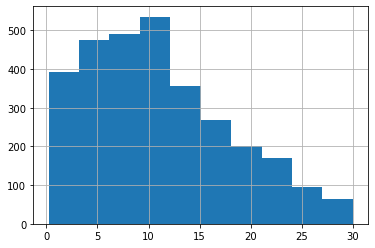

In [30]:
info_df[info_df['duration_min'] <= 30]['duration_min'].hist()

<AxesSubplot:>

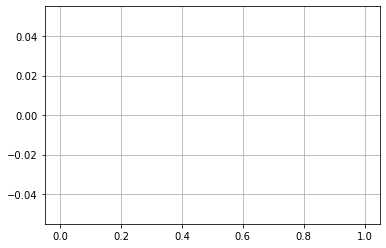

In [31]:
info_df[info_df['duration_min'] > 30]['duration_min'].hist()

In [32]:
info_df = info_df[info_df['duration_min'] <= 30]

In [33]:
info_df.shape

(3045, 7)

### 2.3.1  remove frequent comments
content h爱要改改

In [34]:
# remove freqen comment
content_count = comment_df['en_content'].value_counts()
freq_content = content_count[content_count>10].index
comment_df = comment_df[~comment_df['en_content'].isin(freq_content)]

In [35]:
content_count[content_count>10].to_csv('InitDataset/FreqComments.csv')

### 2.3.2 remove longer than 30 words comments

In [36]:
# 统计content字数和百分数
def count_word(string):
    return len(string.split())
content_word_count = comment_df['en_content'].apply(lambda x: len(x.split()))

In [37]:
content_word_count.describe()

count    254506.000000
mean         20.241810
std          22.206568
min           1.000000
25%           8.000000
50%          14.000000
75%          25.000000
max        1337.000000
Name: en_content, dtype: float64

In [38]:
content_word_count[(content_word_count<30) & (content_word_count>2) ].describe()

count    196041.000000
mean         13.045531
std           7.005390
min           3.000000
25%           7.000000
50%          12.000000
75%          18.000000
max          29.000000
Name: en_content, dtype: float64

In [178]:
comment_df[content_word_count <= 2]

,vid,uid,content,votes,en_content
195,G6mag86ktZA,UgzS4TRZGsdpRPPf41F4AaABAg,"""Nothings cheating!""",34.0,"""Nothings cheating!"""
292,G6mag86ktZA,UgwmX0s5-Zidb_00KAF4AaABAg,Remember,7.0,Remember
2441,tXyYbsHkYEs,UgwpBY7um-kO2HA_ITR4AaABAg,Kriti slayed,15.0,Kriti slayed
2450,tXyYbsHkYEs,UgwVu0O-HZEkN6mXUml4AaABAg,Wow....,13.0,Wow....
2503,tXyYbsHkYEs,UgxIDhUO_nTd8X2v9S94AaABAg,Absolutely stunning 🤩,7.0,Absolutely stunning
...,...,...,...,...,...
2219359,K24iHkQ4umE,UgxXrCFpbElLC6GpUQR4AaABAg,Chathura hora,3.0,Chathura hora
2219406,K24iHkQ4umE,UgwH4GdvxLei3OhgNDp4AaABAg,emathi baba,0.0,emathi baba
2219413,K24iHkQ4umE,UgzrNOqFM2pTu2bOaBB4AaABAg,para ballo,0.0,para ballo
2219414,K24iHkQ4umE,Ugy8Nho8CdyvqIxhGrp4AaABAg,Munta pissu,0.0,Munta pissu


In [39]:
comment_df = comment_df[(content_word_count<=30) & (content_word_count>1)]

### 2.3.3 remove ['music']
要不删了吧 直接把trnscript 太少的删掉

In [40]:
for file in os.listdir(TRANSCRIPT_FOLDER):
    if file == '.DS_Store':
        continue
    path = os.path.join(TRANSCRIPT_FOLDER, file)
    with open(path, 'r')as f:
        reader = csv.reader(f)
        contents = []
        count_music = 0
        count_text = 0
        for line in reader:
            content = line[3]
            if content == '[Music]':
                count_music += 1
            else:
                count_text += 1 
            contents.append(content)
        if count_music>count_text*1.5:
            shutil.move(path, 'InitDataset/deletedTranscripts/'+file)
        
        

In [41]:
# 全部的筛选完成 整合
# 再次去除info/comment/transcript 任一为空的所有信息
transcript_vids = set(file.split('.')[0]for file in os.listdir(TRANSCRIPT_FOLDER))
vids = set(info_df['vid']) & set(comment_df['vid']) & transcript_vids

info_df = info_df[info_df['vid'].isin(vids)].drop_duplicates(['vid'])
comment_df = comment_df[comment_df['vid'].isin(vids)].drop_duplicates(['vid', 'en_content'])
for file in os.listdir(TRANSCRIPT_FOLDER):
    vid = file.split('.')[0]
    path = os.path.join(TRANSCRIPT_FOLDER, file)
    if vid not in vids:
        shutil.move(path, 'InitDataset/deletedTranscripts/'+file)


In [42]:
print('Count:')
print('Information: {}'.format(info_df.shape[0]))
print('Comments: {}'.format(comment_df.shape[0]))
print('Transcript: {}'.format(len(os.listdir(TRANSCRIPT_FOLDER))))

Count:
Information: 2949
Comments: 195440
Transcript: 2949


In [47]:
info_df.to_csv('cleaned/infos.csv',index = None)
comment_df.to_csv('cleaned/comments.csv',index = None)

# 3. DataProfile

In [48]:
info_df

,vid,title,duration,views,tag,duration_min,view_10k
0,G6mag86ktZA,Is there such a thing as Cheating in Art?,52.0,1660431.0,Art,0.866667,166.0431
1,zCe72UH4Mto,Food Storage Tour For Family Of 14 shorts,60.0,357259.0,Food,1.000000,35.7259
2,gspByZ11jjo,FASHION PHOTO RUVIEW: Drag Race: All Stars Sea...,904.0,455895.0,Fashion,15.066667,45.5895
3,YAcVMBJewfI,"Best Pancake Art Wins 5,000 Challenge!",777.0,3562379.0,Art,12.950000,356.2379
4,tXyYbsHkYEs,"Nooraniyat, 2021 A Manish Malhotra Couture Fa...",212.0,841491.0,Fashion,3.533333,84.1491
...,...,...,...,...,...,...,...
3040,2XL61p2E7lw,Chelsea agree 47.5m fee with Manchester City f...,172.0,217568.0,Sport,2.866667,21.7568
3041,MSSi4DoxFFk,I Made a LifeSize Tech Deck!,721.0,1180289.0,Tech,12.016667,118.0289
3042,oQyts-evKyY,WHO DRAWS IT BETTER TAKES THE PRIZE Cool Art ...,1029.0,1281112.0,Art,17.150000,128.1112
3043,w15pCPU2-cA,Nothing Phone (1) Indian Retail Unit Unboxing ...,806.0,2809943.0,Tech,13.433333,280.9943


In [49]:
from matplotlib import pyplot as plt
# comment_df = pd.read_csv('cleaned/comments.csv')
# info_df = pd.read_csv('cleaned/infos.csv')

## 3.1 Information

In [50]:
info_df.describe()

,duration,views,duration_min,view_10k
count,2949.000000,2.949000e+03,2949.000000,2949.000000
mean,665.162767,1.488720e+07,11.086046,1488.719776
std,418.541528,1.421555e+08,6.975692,14215.552333
min,13.000000,1.062000e+03,0.216667,0.106200
25%,315.000000,1.603660e+05,5.250000,16.036600
50%,598.000000,7.321510e+05,9.966667,73.215100
75%,938.000000,2.752324e+06,15.633333,275.232400
max,1800.000000,3.613883e+09,30.000000,361388.324800


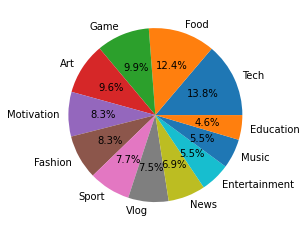

In [51]:
# tag distribution
tags = info_df['tag'].value_counts()
plt.pie(tags, labels=tags.index, autopct='%1.1f%%')
plt.show()

<AxesSubplot:>

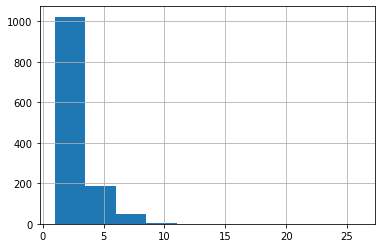

In [52]:
# duration
durations = info_df['duration_min'].value_counts()
durations.hist()

<AxesSubplot:>

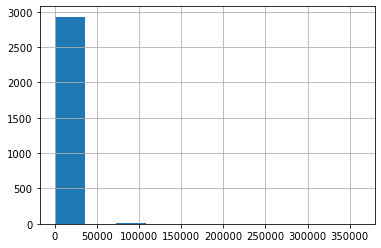

In [53]:
# views
info_df['view_10k'].hist()

## 3.2 Comment

In [54]:
# comments count per video
# average 66 comments per video
comment_df['vid'].value_counts().describe()

count    2949.000000
mean       66.273313
std        23.644169
min         1.000000
25%        54.000000
50%        72.000000
75%        84.000000
max       120.000000
Name: vid, dtype: float64

<AxesSubplot:>

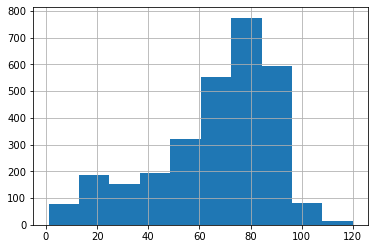

In [55]:
comment_df['vid'].value_counts().hist()

In [56]:
# uid
comment_df['uid'].value_counts().describe()

count    193982.000000
mean          1.007516
std           0.086370
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           2.000000
Name: uid, dtype: float64

<AxesSubplot:>

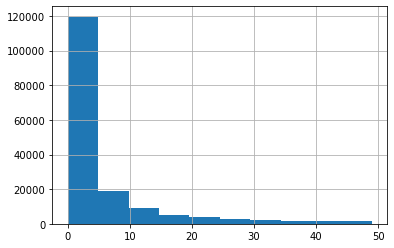

In [57]:
# votes
comment_df[comment_df.votes<50]['votes'].hist()

In [58]:
# contents
comment_df['en_content'].value_counts().head(10)

I love this channel                                                               10
If you don't build your dream someone else will hire you to help build theirs.     9
Good job                                                                           9
Great job                                                                          9
Despite the economic downturn,I'm so happy                                         9
Thank you.                                                                         9
Jai Hind  sir                                                                      9
Love your vids                                                                     9
Very beautiful                                                                     9
O nation of Muhammad                                                               8
Name: en_content, dtype: int64

## 3.3 Transcript

In [59]:
# word count
pass

# 各tag的综合分析
检查不同tag的平均时长/transcript字数/评论数/有没有区别

In [60]:
for tag in tags.index:
    print('='*50)
    print(tag)
    print(info_df[info_df.tag == tag]['duration_min'].mean())

Tech
12.717826460481099
Food
11.539589302769818
Game
10.468824940047961
Art
10.74567901234568
Motivation
9.391201716738196
Fashion
11.826652298850577
Sport
9.751382488479264
Vlog
13.551184834123223
News
9.00897435897436
Entertainment
8.447970085470088
Music
4.15021645021645
Education
9.355426356589149


In [88]:
for file in os.listdir('Cleaned/Transcripts/'):
    if not file.endswith('.csv'):
        continue
    path = os.path.join('Cleaned/Transcripts',file)
    vid = file.split('.')[0]
    transcript = pd.read_csv(path)
    texts = ' '.join(transcript['text'])
    with open('Cleaned/Transcripts-txt/'+vid+'.txt', 'w')as f:
        f.write(texts)
    

In [89]:
DATASET_PATH = 'Cleaned/'
TRANSCRIPT_PATH = 'Cleaned/Transcripts-txt/'
INFO_PATH = 'Cleaned/infos.csv'
COMMENT_PATH = 'Cleaned/comments.csv'

In [94]:
info_df = pd.read_csv(INFO_PATH)
comment_df = pd.read_csv(COMMENT_PATH)

In [91]:
info_df = info_df[['vid','title']]
comment_df = comment_df[['vid','en_content']]
data = pd.merge(info_df, comment_df, how="inner", on='vid')

In [92]:
def get_transcript(vid):
    file = TRANSCRIPT_PATH+vid+'.txt'
    with open(file, 'r')as f:
        return f.read()
    
data['transcript'] = data['vid'].apply(get_transcript)

In [93]:
data

,vid,title,en_content,transcript
0,G6mag86ktZA,Is there such a thing as Cheating in Art?,The only thing cheating in art is claiming an ...,okay we need to talk about cheating and art ev...
1,G6mag86ktZA,Is there such a thing as Cheating in Art?,"""There is no cheating in art""",okay we need to talk about cheating and art ev...
2,G6mag86ktZA,Is there such a thing as Cheating in Art?,Dont listen to ppl you never met on the internet,okay we need to talk about cheating and art ev...
3,G6mag86ktZA,Is there such a thing as Cheating in Art?,Also tracing can help you get used to differen...,okay we need to talk about cheating and art ev...
4,G6mag86ktZA,Is there such a thing as Cheating in Art?,"""There's only one rule and that is to have fun.""",okay we need to talk about cheating and art ev...
...,...,...,...,...
195435,_1AjMAPtmtQ,Japan swelters in its worst heatwave ever reco...,Its definitely worrying that climate change is...,in japan we've been telling you about the unpr...
195436,_1AjMAPtmtQ,Japan swelters in its worst heatwave ever reco...,Last year in western Oregon it was 117F or 47C...,in japan we've been telling you about the unpr...
195437,_1AjMAPtmtQ,Japan swelters in its worst heatwave ever reco...,"I'm fine in a dry 110115F climate, but I canno...",in japan we've been telling you about the unpr...
195438,_1AjMAPtmtQ,Japan swelters in its worst heatwave ever reco...,I ain't seen our allies go through this of eve...,in japan we've been telling you about the unpr...


In [83]:
data.to_csv('Cleaned/data.csv')

In [95]:
video_data = info_df[['vid','title','tag']]
video_data['transcript'] = video_data['vid'].apply(get_transcript)

<ipython-input-95-80ff38c01aa2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  video_data['transcript'] = video_data['vid'].apply(get_transcript)


In [96]:
video_datab

,vid,title,tag,transcript
0,G6mag86ktZA,Is there such a thing as Cheating in Art?,Art,okay we need to talk about cheating and art ev...
1,zCe72UH4Mto,Food Storage Tour For Family Of 14 shorts,Food,food storage tour for my family of 14. this is...
2,gspByZ11jjo,FASHION PHOTO RUVIEW: Drag Race: All Stars Sea...,Fashion,hello everyone it is me violet tchotchke and w...
3,YAcVMBJewfI,"Best Pancake Art Wins 5,000 Challenge!",Art,today we will be making pancake art and whiche...
4,tXyYbsHkYEs,"Nooraniyat, 2021 A Manish Malhotra Couture Fa...",Fashion,but i can't help falling in love with you shal...
...,...,...,...,...
2944,2XL61p2E7lw,Chelsea agree 47.5m fee with Manchester City f...,Sport,raheem sterling is now on the verge of a move ...
2945,MSSi4DoxFFk,I Made a LifeSize Tech Deck!,Tech,hey yo wait what [Music] real quick before thi...
2946,oQyts-evKyY,WHO DRAWS IT BETTER TAKES THE PRIZE Cool Art ...,Art,welcome to the drawing challenge and look who ...
2947,w15pCPU2-cA,Nothing Phone (1) Indian Retail Unit Unboxing ...,Tech,The most exciting launch of 2022 is inside thi...


In [99]:
comment_df[['vid', 'en_content']].to_csv('comment_data.csv')

In [97]:
video_data.to_csv('video_data.csv')